# Internal structures of time series

In this section, we explain the following special characteristics of time series data that requires its special mathematical treatment:

    * General trend
    * Seasonality
    * Cyclical movements
    * Unexpected variations




# General trend

When a time series exhibits an upward or downward movement in the long run, it is said to have a general trend. A quick way to check the presence of general trend is to plot the time series as in the following figure, which shows CO2 concentrations in air measured during 1974 through 1987:


In [1]:
from __future__ import print_function
import os
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# os.chdir('D:/Practical Time Series/')

In [3]:
data = pd.read_excel('datasets/Monthly_CO2_Concentrations.xlsx',
                     converters={'Year': np.int32, 'Month': np.int32})

In [4]:
data.head()

,CO2,Year,Month
0,333.13,1974,5
1,332.09,1974,6
2,331.10,1974,7
3,329.14,1974,8
4,327.36,1974,9


In [5]:
#Create row index of the DataFrame using the Year and Month columns
data.index = data['Year'].astype(str) + '-' + data['Month'].astype(str).map(lambda x: '0'+x if len(x) == 1 else x)
data.head()

,CO2,Year,Month
1974-05,333.13,1974,5
1974-06,332.09,1974,6
1974-07,331.10,1974,7
1974-08,329.14,1974,8
1974-09,327.36,1974,9


Before plotting we must remove all columns having missing values. Besides, the DataFrame is sorted in ascending order of Year and Month. These are done as follows:

In [6]:
data = data.loc[(~pd.isnull(data['CO2']))&\
                (~pd.isnull(data['Year']))&\
                (~pd.isnull(data['Month']))]

In [7]:
data.sort_values(['Year', 'Month'], inplace=True)

Finally, the plot for the time period 1974 to 1987 is generated by executing the following lines:

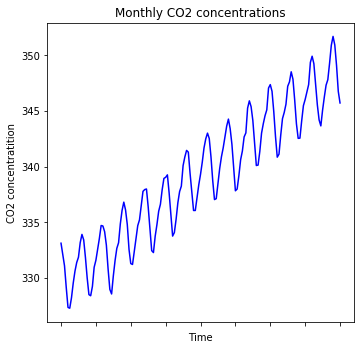

In [8]:
plt.figure(figsize=(5.5, 5.5))
data['CO2'].plot(color='b')
plt.title('Monthly CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition')
plt.xticks(rotation=30)
plt.savefig('plots/B07887_01_05.png', format='png', dpi=300)

The zoomed-in version of the data for the time period 1980 to 1981 is generated by after the DataFrame for these three years:

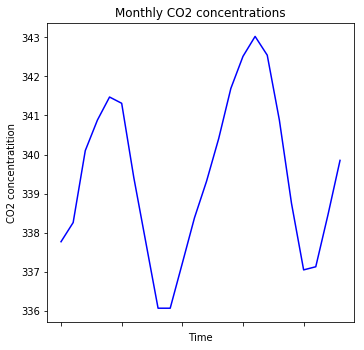

In [11]:
plt.figure(figsize=(5.5, 5.5))
data['CO2'].loc[(data['Year']==1980) | (data['Year']==1981)].plot(color='b')
plt.title('Monthly CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition')
plt.xticks(rotation=30)
plt.savefig('plots/B07887_01_06.png', format='png', dpi=300)

Next, let us fit the trend line. For this we import the LinearRegression class from scikit-learn and fit a linear model on the time index:

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
trend_model = LinearRegression(normalize=True, fit_intercept=True)
trend_model.fit(np.arange(data.shape[0]).reshape((-1,1)), data['CO2'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [14]:
print('Trend model coefficient={} and intercept={}'.format(trend_model.coef_[0],
                                                           trend_model.intercept_)
      )

Trend model coefficient=0.1209930124223602 and intercept=329.45310559006214


<b> Note: </b> The residuals obtained from the trend line model are shown in the following figure and appear to have seasonal behaviour, which is discussed in the next sub section.

The residuals are calculated and plotted in the preceding by the following lines of code:

In [15]:
residuals = np.array(data['CO2']) - trend_model.predict(np.arange(data.shape[0]).reshape((-1,1)))

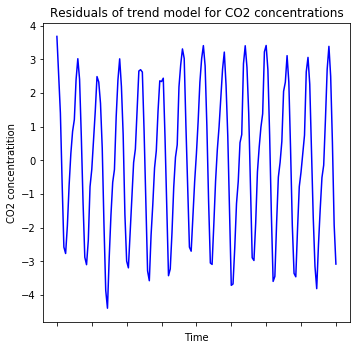

In [16]:
plt.figure(figsize=(5.5, 5.5))
pd.Series(data=residuals, index=data.index).plot(color='b')
plt.title('Residuals of trend model for CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition')
plt.xticks(rotation=30)
plt.savefig('plots/B07887_01_07.png', format='png', dpi=300)

# Seasonality

Seasonality manifests as repetitive and period variations in a time series. In most cases, exploratory data analysis reveals the presence of seasonality. Let us revisit the de-trended time series of the CO2 concentrations. Though the de-trended line series has constant mean and constant variance, it systematically departs from the trend model in a predictable fashion.
<br>
Seasonality is manifested as periodic deviations such as those seen in the de-trended observations of CO2 emissions. Peaks and troughs in the monthly sales volume of seasonal goods such as Christmas gifts or seasonal clothing is another example of a time series with seasonality.
<br><br>
A practical technique of determining seasonality is through exploratory data analysis through the following plots:

    * Run sequence plot
    * Seasonal sub series plot
    * Multiple box plots


# Run sequence plot

A simple run sequence plot of the original time series with time on x-axis and the variable on y-axis is good for indicating the following properties of the time series:

    - Movements in mean of the series
    - Shifts in variance
    - Presence of outliers

In cases such as this, a run sequence plot is an effective way of identifying shifting mean and variance of the series as well as outliers. The plot of the de-trended time series of the CO2 concentrations is an example of a run sequence plot.


# Seasonal sub series plot

For a known periodicity of seasonal variations, seasonal sub series redraws the original series over batches of successive time periods. For example, the periodicity in the CO2 concentrations is 12 months and based on this a seasonal sub series plots on mean and standard deviation of the residuals are shown in the following figure. To visualize seasonality in the residuals, we create quarterly mean and standard deviations.

A seasonal sub series reveals two properties:

    - Variations within seasons as within a batch of successive months
    - Variations between seasons as between batches of successive months

<br><br>
First, we need to add the residuals and quarter labels to the CO2 concentrations DataFrame. This is done as follows:

In [18]:
data['Residuals'] = residuals
month_quarter_map = {1: 'Q1', 2: 'Q1', 3: 'Q1',
                     4: 'Q2', 5: 'Q2', 6: 'Q2',
                     7: 'Q3', 8: 'Q3', 9: 'Q3',
                     10: 'Q4', 11: 'Q4', 12: 'Q4'
                    }
data['Quarter'] = data['Month'].map(lambda m: month_quarter_map.get(m))

Next, the seasonal mean and standard deviations are computed by grouping by the data over Year and Quarter:

In [19]:
seasonal_sub_series_data = data.groupby(by=['Year', 'Quarter'])['Residuals'].aggregate([np.mean, np.std])
seasonal_sub_series_data.columns = ['Quarterly Mean', 'Quarterly Standard Deviation']

This creates the new DataFrame as seasonal_sub_series_data, which has quarterly mean and standard deviations over the years. These columns are renamed as follows:

In [20]:
#Create row indices of seasonal_sub_series_data using Year & Quarter
seasonal_sub_series_data.reset_index(inplace=True)
seasonal_sub_series_data.index = seasonal_sub_series_data['Year'].astype(str) + '-' + seasonal_sub_series_data['Quarter']
seasonal_sub_series_data.head()

,Year,Quarter,Quarterly Mean,Quarterly Standard Deviation
1974-Q2,1974,Q2,3.096398,0.820946
1974-Q3,1974,Q3,-0.616085,1.991671
1974-Q4,1974,Q4,-1.822397,1.014952
1975-Q1,1975,Q1,0.754624,0.511890
1975-Q2,1975,Q2,2.604978,0.355093


Next, the quarterly mean and standard deviations are plotted by running the following lines of code:

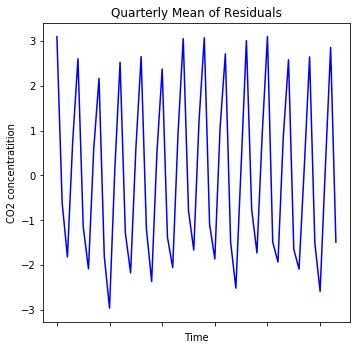

In [21]:
plt.figure(figsize=(5.5, 5.5))
seasonal_sub_series_data['Quarterly Mean'].plot(color='b')
plt.title('Quarterly Mean of Residuals')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition')
plt.xticks(rotation=30)
plt.savefig('plots/B07887_01_08.png', format='png', dpi=300)

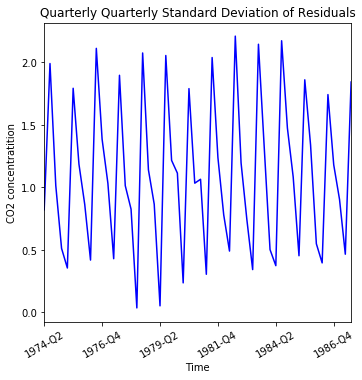

In [30]:
plt.figure(figsize=(5.5, 5.5))
seasonal_sub_series_data['Quarterly Standard Deviation'].plot(color='b')
plt.title('Quarterly Quarterly Standard Deviation of Residuals')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition')
plt.xticks(rotation=30)
plt.savefig('plots/B07887_01_09.png', format='png', dpi=300)

# Multiple box plots

The seasonal sub series plot can be more informative when redrawn with seasonal box plots as shown in the following figure. A box plot displays both central tendency and dispersion within the seasonal data over a batch of time units. Besides, separation between two adjacent box plots reveal the within season variations:

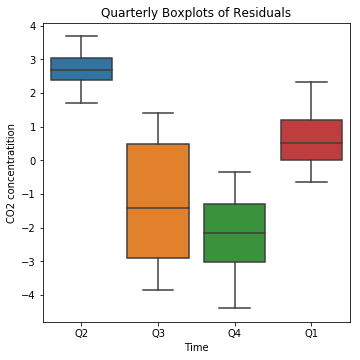

In [22]:
#Multiple box plots to visualize central tendency and dispersion of seasonal sub series
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(data=data, y='Residuals', x='Quarter')
g.set_title('Quarterly Boxplots of Residuals')
g.set_xlabel('Time')
g.set_ylabel('CO2 concentratition')
plt.savefig('plots/B07887_01_10.png', format='png', dpi=300)

# Cyclical changes

Cyclical changes are movements observed after every few units of time, but they occur less frequently than seasonal fluctuations. Unlike seasonality, cyclical changes might not have a fixed period of variations. Besides, the average periodicity for cyclical changes would be larger (most commonly in years), whereas seasonal variations are observed within the same year and corresponds to annual divisions of time such as seasons, quarters, and periods of festivity and holidays and so on.

A long run plot of the time series is required to identify cyclical changes that can occur, for example, every few years and manifests as repetitive crests and troughs. In this regard, time series related to economics and business often show cyclical changes that correspond to usual business and macroeconomic cycles such as periods of recessions followed by every of boom, but are separated by few years of time span. Similar to general trends, identifying cyclical movements might require data that dates significantly back in the past.

The following figure illustrates cyclical changes occurring in inflation of consumer price index (CPI) for India and United States over the period of 1960 through 2016. Both the countries exhibit cyclical patterns in CPI inflation, which is roughly over a period of 2-2.5 years. Moreover, CPI inflation of India has larger variations pre-1990 than that seen after 1990.

In [23]:
inflation = pd.read_excel('datasets/inflation-consumer-prices-annual.xlsx', parse_dates=['Year'])

In [24]:
inflation.head()

,Year,India,United States
0,1960-01-01,1.783265,1.509929
1,1961-01-01,1.752022,1.075182
2,1962-01-01,3.576159,1.116071
3,1963-01-01,2.941176,1.214128
4,1964-01-01,13.354037,1.308615


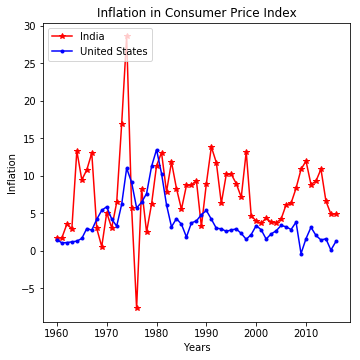

In [25]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(1960,2017), inflation['India'], linestyle='-', marker='*', color='r')
plt.plot(range(1960,2017), inflation['United States'], linestyle='-', marker='.', color='b')
plt.legend(['India','United States'], loc=2)
plt.title('Inflation in Consumer Price Index')
plt.ylabel('Inflation')
plt.xlabel('Years')
plt.savefig('plots/B07887_01_11.png', format='png', dpi=300)